# Result Analysis

## Imports

In [19]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py

from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr

## Inputs

In [5]:
lpms_directory = os.path.abspath("./data/lpms") # this is the directory that includes the sets of local process models
scripts_directory = os.path.abspath("./scripts/clustering")

res_directory = os.path.abspath("results") # this it the directory where results will be outputted
analysis_directory = os.path.abspath("analysis")

In [15]:
measures = {"full":"full_trace_matching", "efg":"efg", "ged":"ged", "node":"node", "transition":"transition_label"}

In [10]:
cl_res_df = pd.read_csv(os.path.join(res_directory, "ss", "complete_ss.csv"))
cl_res_df

,Event Log,Distance Threshold,Measure,Num Clusters,efg,full,ged,node,transition
0,artificialBig,0.1,efg,7,0.326725,0.352304,0.015030,0.021521,0.000000
1,artificialBig,0.1,full,13,0.200000,0.200000,-0.043627,-0.041932,0.000000
2,artificialBig,0.1,ged,12,-0.100548,-0.020794,0.141001,0.061193,0.006667
3,artificialBig,0.1,node,8,0.066172,-0.093645,0.099880,0.141117,0.000000
4,artificialBig,0.1,transition,4,0.626159,0.223752,0.206445,0.493255,0.800000
...,...,...,...,...,...,...,...,...,...
90,artificialBig,0.5,node,2,0.720554,0.512188,0.539562,0.756821,0.891761
91,artificialBig,0.5,transition,2,0.720554,0.512188,0.539562,0.756821,0.891761
92,artificialBig,0.6,efg,3,0.662602,0.359817,0.401290,0.632480,0.800000
93,artificialBig,0.7,efg,2,0.720554,0.512188,0.539562,0.756821,0.891761


In [12]:
# transform to different format
cl_res_df_ss = pd.melt(cl_res_df,
                       id_vars=['Event Log', "Measure", "Distance Threshold", "Num Clusters"],
                       value_vars=['efg', 'full', 'ged', 'node', 'transition'],
                       var_name='ss_measure', value_name='ss')
cl_res_df_ss["self"] = cl_res_df_ss.apply(lambda row: "yes" if row["ss_measure"] == row["Measure"] else "no", axis=1)

In [33]:
# keep only rows for self ss
self_df_ss = cl_res_df_ss[cl_res_df_ss.apply(lambda row: row["Measure"]==measures[row["ss_measure"]], axis=1)]

In [36]:
idx = self_df_ss.groupby(['Measure'])['Num Clusters'].transform(max) == self_df_ss['Num Clusters']
df_ss_max = self_df_ss[idx]
df_ss_max.drop_duplicates(["Measure", "Num Clusters"])

,Event Log,Measure,Distance Threshold,Num Clusters,ss_measure,ss,self
31,artificialBig,efg,0.1,10,efg,0.282512,yes
192,artificialBig,ged,0.1,12,ged,0.141001,yes
319,artificialBig,node,0.1,9,node,0.107947,yes


## Correlation Analysis

In [6]:
pearson = pd.DataFrame(index=cl_res_df['Measure'].unique(), columns=cl_res_df['Measure'].unique())

measures = ["full", "efg", "ged", "node", "transition"]

for measure1 in measures:
    for measure2 in measures:
        corr, _ = pearsonr(cl_res_df[measure1], cl_res_df[measure2])
        pearson[measure1][measure2] = corr

pearson.to_csv(os.path.join(analysis_directory, "pearson.csv"))

## Cluster Compactness

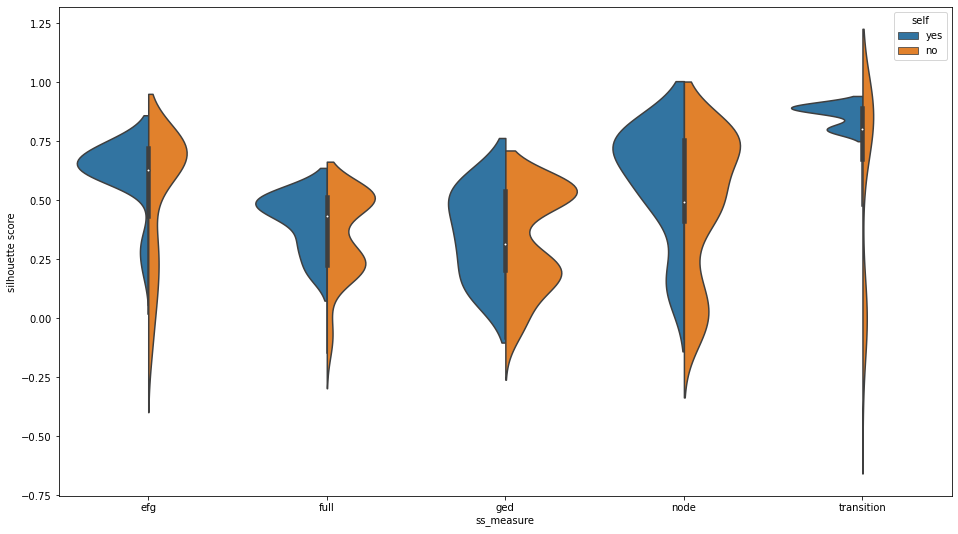

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))

data = cl_res_df_ss
sns.violinplot(ax=ax, data=data, x="ss_measure", y="ss", hue="self", split=True)
ax.set(ylabel='silhouette score')

fig.savefig(os.path.join(analysis_directory, "ss_violin.svg"))

# Export clusters

In [25]:
for ind, row in df_ss_max.iterrows():
    log = row["Event Log"]
    thr = row["Distance Threshold"]
    measure = measures[row["Measure"]]
    cl = pd.read_csv(os.path.join(res_directory,
                                  log,
                                  "clustering",
                                  "clustering_hierarchical_complete_{thr}_{measure}_distances.csv".format(thr=thr, measure=measure)),
                     index_col=0)


    lpms_dir = os.path.abspath(os.path.join(lpms_directory, log))
    dir_cl_nets = os.path.abspath(os.path.join(analysis_directory, "cluster_nets", log))
    if not os.path.exists(dir_cl_nets): os.makedirs(dir_cl_nets)

    ind = 0
    for label in cl["Labels"].unique():
        net_files = cl.loc[cl["Labels"]==label]["Nets"]
        for file in net_files:
            cluster_dir = os.path.join(dir_cl_nets, str(label))
            if not os.path.exists(cluster_dir): os.mkdir(cluster_dir)
            net = pm4py.read_pnml(os.path.join(lpms_dir, file))
            pm4py.save_vis_petri_net(*net, file_path=os.path.join(cluster_dir, "net"+str(ind)+".svg"))
            ind = ind+1

## Repetition Analysis

In [30]:
# read lpm datasets
lpm_sets = [name for name in os.listdir(lpms_directory) if os.path.isdir(os.path.join(lpms_directory, name))]
lpm_sets_res = {}
for lpm_set in lpm_sets:
    lpm_sets_res[lpm_set] = pd.read_csv(os.path.join(lpms_directory, lpm_set, lpm_set + ".csv"))

here
here


C:\Users\peeva\AppData\Roaming\Python\Python38\site-packages\seaborn\_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

<Figure size 432x288 with 0 Axes>

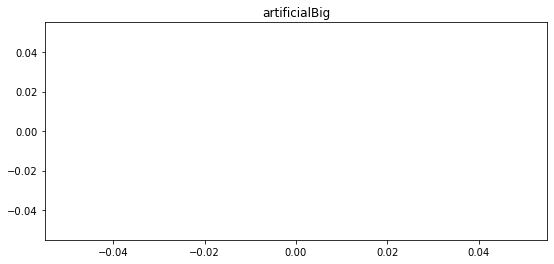

In [40]:
plt.tight_layout()
count_plots = len(lpm_sets)
fig, axs = plt.subplots(count_plots, 1, figsize=(9,4*count_plots))

x = [5, 10, 20, 50, 100]
ind = 0
for log in lpm_sets_res.keys():
    curr_ax = axs
    if count_plots > 1:
        curr_ax = axs[ind]

    df_log = pd.DataFrame({'Original LPMs': pd.Series(dtype='int'), 'Representative LPMs': pd.Series(dtype='int'), 'Measure': pd.Series(dtype='str')})
    for measure in measures:
        df_ss_one = df_ss_max.loc[(df_ss_max["Event Log"]==log) & (df_ss_max["ss_measure"]==measure)]
        if len(df_ss_one) <= 0:
            print("here")
            continue
        for dist_threshold in df_ss_one["Distance Threshold"].unique():
            file = "clustering_hierarchical_complete_" + str(dist_threshold) + "_" + measures[measure] + "_" + "distances.csv"
            if not os.path.exists(os.path.join(res_directory, log, "clustering", file)): continue
            df_clust = pd.read_csv(os.path.join(res_directory, log, "clustering", file), index_col=0)
            df_clust = pd.merge(df_clust, lpm_sets_res[log], left_on="Nets", right_on="Name")
            df_clust.sort_values("Aggregated Score", axis=0, inplace=True, ascending=False)
            y = [len(df_clust.iloc[:xone]["Labels"].unique()) for xone in x]
            curr_df = pd.DataFrame(data = {'Original LPMs': x, 'Representative LPMs': y, 'Measure': [measure] * 5})
            df_log = pd.concat([df_log, curr_df])
    curr_ax.set(title=log)
    legend = curr_ax.get_legend()
    if legend is not None: legend.remove()
    sns.lineplot(ax=curr_ax, data = df_log, x="Original LPMs", y="Representative LPMs", hue="Measure")
    ind = ind + 1

# fig.legend(loc="upper left")
fig.savefig(os.path.join(analysis_directory, "model_repetition.svg"))